<a href="https://colab.research.google.com/github/gantir/eva4/blob/develop/s6/EVA4_Session_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Cuda available?', use_cuda)

Cuda available? True


In [3]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive/')
  sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4')
except:
  print('May be not using Google Colab')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
from utils.model_helper import train_model, test_model, train_n_test
from utils.plot_helper import plot_acc_loss

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
# Prepare Train and Test Dataset

train_dataset = datasets.MNIST('../data', train=True, download=True, transform= train_transforms)
test_dataset = datasets.MNIST('../data', train=False, transform=test_transforms)

In [0]:
SEED = 1

torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True, 'batch_size': batch_size} if use_cuda else {'batch_size': 64}
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader( test_dataset , shuffle=True, **kwargs)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


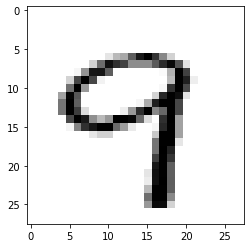

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_dataset.train_data
train_data = train_dataset.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_dataset.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_dataset.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


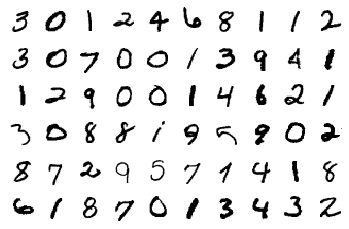

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_value = 0.1

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        )#input:26x26x8, output:24x24x8, RF:5x5
        
        self.pool1 = nn.MaxPool2d(2, 2) #input - 24*24*8 output: 12*12*8 RF: 6*6
        self.conv_one_one_1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        )#input:12x12x8, output:12x12x8, RF:6x6

        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        )#input:12x12x8, output:10x10x16, RF:10x10
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.conv_block6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x20, RF:22x22

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )  #input -6*6*20 output: 1*1*20 RF:32x32

        self.conv_one_one_2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x20, output:1x1x10,


    def forward(self, x):
        x = self.conv_block2(self.conv_block1(x))

        x = self.conv_one_one_1(self.pool1(x))

        x = self.conv_block4(self.conv_block3(x))
        x = self.conv_block6(self.conv_block5(x))

        x = self.gap(x)
        x = self.conv_one_one_2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [11]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

Epoch: 1, Batch 937,  Training Loss: 0.09029733 Training Accuracy: 92.8367%: 100%|██████████| 938/938 [00:15<00:00, 61.84it/s]

LR: [0.199]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 1 -- Test Set, Validation Loss: 0.05578894 Validation Accuracy: 98.2000%



Epoch: 2, Batch 937,  Training Loss: 0.16601670 Training Accuracy: 97.4300%: 100%|██████████| 938/938 [00:16<00:00, 58.09it/s]


LR: [0.19899500003140708]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 2 -- Test Set, Validation Loss: 0.03231527 Validation Accuracy: 98.9600%



Epoch: 3, Batch 937,  Training Loss: 0.01533708 Training Accuracy: 97.9017%: 100%|██████████| 938/938 [00:15<00:00, 58.30it/s]

LR: [0.19899250009422076]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 3 -- Test Set, Validation Loss: 0.02759745 Validation Accuracy: 99.0200%



Epoch: 4, Batch 937,  Training Loss: 0.02180766 Training Accuracy: 98.2050%: 100%|██████████| 938/938 [00:15<00:00, 59.66it/s]

LR: [0.1989900001884407]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 4 -- Test Set, Validation Loss: 0.02288760 Validation Accuracy: 99.2800%



Epoch: 5, Batch 937,  Training Loss: 0.30207202 Training Accuracy: 98.4100%: 100%|██████████| 938/938 [00:16<00:00, 57.91it/s]


LR: [0.1989875003140665]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 5 -- Test Set, Validation Loss: 0.02810768 Validation Accuracy: 99.1000%



Epoch: 6, Batch 937,  Training Loss: 0.02391137 Training Accuracy: 98.4867%: 100%|██████████| 938/938 [00:16<00:00, 57.79it/s]

LR: [0.19898500047109777]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 6 -- Test Set, Validation Loss: 0.03068501 Validation Accuracy: 99.0100%



Epoch: 7, Batch 937,  Training Loss: 0.08276889 Training Accuracy: 98.6217%: 100%|██████████| 938/938 [00:16<00:00, 57.87it/s]

LR: [0.19898250065953407]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 7 -- Test Set, Validation Loss: 0.02868492 Validation Accuracy: 98.9600%



Epoch: 8, Batch 937,  Training Loss: 0.06914635 Training Accuracy: 98.5567%: 100%|██████████| 938/938 [00:15<00:00, 59.39it/s]

LR: [0.19898000087937506]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 8 -- Test Set, Validation Loss: 0.02775802 Validation Accuracy: 99.1200%



Epoch: 9, Batch 937,  Training Loss: 0.10436742 Training Accuracy: 98.6283%: 100%|██████████| 938/938 [00:16<00:00, 56.74it/s]


LR: [0.19897750113062032]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 9 -- Test Set, Validation Loss: 0.02407864 Validation Accuracy: 99.2400%



Epoch: 10, Batch 937,  Training Loss: 0.01517373 Training Accuracy: 98.6817%: 100%|██████████| 938/938 [00:15<00:00, 59.85it/s]

LR: [0.19897500141326946]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 10 -- Test Set, Validation Loss: 0.02177260 Validation Accuracy: 99.2600%



Epoch: 11, Batch 937,  Training Loss: 0.01078288 Training Accuracy: 98.6933%: 100%|██████████| 938/938 [00:16<00:00, 57.70it/s]

LR: [0.1989725017273221]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 11 -- Test Set, Validation Loss: 0.02379889 Validation Accuracy: 99.2800%



Epoch: 12, Batch 937,  Training Loss: 0.00135890 Training Accuracy: 98.7350%: 100%|██████████| 938/938 [00:17<00:00, 54.53it/s]

LR: [0.1989700020727778]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 12 -- Test Set, Validation Loss: 0.02063133 Validation Accuracy: 99.2900%



Epoch: 13, Batch 937,  Training Loss: 0.00089231 Training Accuracy: 98.8267%: 100%|██████████| 938/938 [00:16<00:00, 57.74it/s]

LR: [0.19896750244963618]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 13 -- Test Set, Validation Loss: 0.01974601 Validation Accuracy: 99.3000%



Epoch: 14, Batch 937,  Training Loss: 0.04628661 Training Accuracy: 98.8483%: 100%|██████████| 938/938 [00:16<00:00, 55.62it/s]


LR: [0.1989650028578969]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 14 -- Test Set, Validation Loss: 0.01950439 Validation Accuracy: 99.3300%



Epoch: 15, Batch 937,  Training Loss: 0.00796837 Training Accuracy: 98.8967%: 100%|██████████| 938/938 [00:18<00:00, 45.56it/s]

LR: [0.19896250329755952]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 15 -- Test Set, Validation Loss: 0.02356400 Validation Accuracy: 99.2400%



Epoch: 16, Batch 937,  Training Loss: 0.00529742 Training Accuracy: 98.9367%: 100%|██████████| 938/938 [00:16<00:00, 55.60it/s]

LR: [0.19896000376862363]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 16 -- Test Set, Validation Loss: 0.01903867 Validation Accuracy: 99.3700%



Epoch: 17, Batch 937,  Training Loss: 0.00183845 Training Accuracy: 98.9550%: 100%|██████████| 938/938 [00:17<00:00, 52.82it/s]

LR: [0.19895750427108888]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 17 -- Test Set, Validation Loss: 0.02685769 Validation Accuracy: 99.1900%



Epoch: 18, Batch 937,  Training Loss: 0.01892352 Training Accuracy: 98.9683%: 100%|██████████| 938/938 [00:17<00:00, 61.35it/s]

LR: [0.19895500480495484]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 18 -- Test Set, Validation Loss: 0.02122241 Validation Accuracy: 99.2800%



Epoch: 19, Batch 937,  Training Loss: 0.16356109 Training Accuracy: 98.9267%: 100%|██████████| 938/938 [00:17<00:00, 53.68it/s]

LR: [0.19895250537022113]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 19 -- Test Set, Validation Loss: 0.01803750 Validation Accuracy: 99.4300%



Epoch: 20, Batch 937,  Training Loss: 0.04184438 Training Accuracy: 98.9217%: 100%|██████████| 938/938 [00:17<00:00, 53.58it/s]

LR: [0.19895000596688736]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 20 -- Test Set, Validation Loss: 0.02353881 Validation Accuracy: 99.1800%



Epoch: 21, Batch 937,  Training Loss: 0.04453966 Training Accuracy: 98.9983%: 100%|██████████| 938/938 [00:17<00:00, 53.70it/s]

LR: [0.1989475065949531]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 21 -- Test Set, Validation Loss: 0.02282409 Validation Accuracy: 99.2700%



Epoch: 22, Batch 937,  Training Loss: 0.01283640 Training Accuracy: 99.0167%: 100%|██████████| 938/938 [00:18<00:00, 50.24it/s]

LR: [0.19894500725441802]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 22 -- Test Set, Validation Loss: 0.02795478 Validation Accuracy: 99.1800%



Epoch: 23, Batch 937,  Training Loss: 0.00370371 Training Accuracy: 99.0000%: 100%|██████████| 938/938 [00:16<00:00, 55.38it/s]


LR: [0.19894250794528168]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 23 -- Test Set, Validation Loss: 0.02171144 Validation Accuracy: 99.2300%



Epoch: 24, Batch 937,  Training Loss: 0.00348023 Training Accuracy: 98.9667%: 100%|██████████| 938/938 [00:17<00:00, 54.49it/s]

LR: [0.1989400086675437]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 24 -- Test Set, Validation Loss: 0.01920616 Validation Accuracy: 99.3400%



Epoch: 25, Batch 937,  Training Loss: 0.03716515 Training Accuracy: 99.0400%: 100%|██████████| 938/938 [00:18<00:00, 51.15it/s]

LR: [0.19893750942120367]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 25 -- Test Set, Validation Loss: 0.02090878 Validation Accuracy: 99.3100%



Epoch: 26, Batch 937,  Training Loss: 0.00947668 Training Accuracy: 99.0800%: 100%|██████████| 938/938 [00:18<00:00, 50.69it/s]

LR: [0.1989350102062612]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 26 -- Test Set, Validation Loss: 0.01668025 Validation Accuracy: 99.4600%



Epoch: 27, Batch 937,  Training Loss: 0.23356503 Training Accuracy: 99.0850%: 100%|██████████| 938/938 [00:19<00:00, 50.66it/s]

LR: [0.19893251102271592]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 27 -- Test Set, Validation Loss: 0.01934259 Validation Accuracy: 99.3400%



Epoch: 28, Batch 937,  Training Loss: 0.00274172 Training Accuracy: 99.1083%: 100%|██████████| 938/938 [00:19<00:00, 47.86it/s]

LR: [0.1989300118705674]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 28 -- Test Set, Validation Loss: 0.01936964 Validation Accuracy: 99.3500%



Epoch: 29, Batch 937,  Training Loss: 0.01731861 Training Accuracy: 99.0617%: 100%|██████████| 938/938 [00:18<00:00, 51.13it/s]

LR: [0.1989275127498153]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 29 -- Test Set, Validation Loss: 0.01476381 Validation Accuracy: 99.5900%



Epoch: 30, Batch 937,  Training Loss: 0.00300631 Training Accuracy: 99.1533%: 100%|██████████| 938/938 [00:19<00:00, 48.02it/s]

LR: [0.19892501366045917]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 30 -- Test Set, Validation Loss: 0.02042780 Validation Accuracy: 99.3500%



Epoch: 31, Batch 937,  Training Loss: 0.00145990 Training Accuracy: 99.1017%: 100%|██████████| 938/938 [00:18<00:00, 50.03it/s]


LR: [0.19892251460249863]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 31 -- Test Set, Validation Loss: 0.01891830 Validation Accuracy: 99.4500%



Epoch: 32, Batch 937,  Training Loss: 0.06187161 Training Accuracy: 99.1250%: 100%|██████████| 938/938 [00:17<00:00, 52.46it/s]


LR: [0.19892001557593328]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 32 -- Test Set, Validation Loss: 0.01604497 Validation Accuracy: 99.4700%



Epoch: 33, Batch 937,  Training Loss: 0.01576655 Training Accuracy: 99.1717%: 100%|██████████| 938/938 [00:18<00:00, 50.60it/s]

LR: [0.19891751658076276]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 33 -- Test Set, Validation Loss: 0.02005501 Validation Accuracy: 99.3200%



Epoch: 34, Batch 937,  Training Loss: 0.00034437 Training Accuracy: 99.1067%: 100%|██████████| 938/938 [00:17<00:00, 54.56it/s]


LR: [0.19891501761698663]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 34 -- Test Set, Validation Loss: 0.02175758 Validation Accuracy: 99.2900%



Epoch: 35, Batch 937,  Training Loss: 0.00494033 Training Accuracy: 99.1467%: 100%|██████████| 938/938 [00:16<00:00, 55.28it/s]

LR: [0.19891251868460452]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 35 -- Test Set, Validation Loss: 0.01935808 Validation Accuracy: 99.3300%



Epoch: 36, Batch 937,  Training Loss: 0.00146902 Training Accuracy: 99.1183%: 100%|██████████| 938/938 [00:17<00:00, 54.41it/s]


LR: [0.19891001978361605]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 36 -- Test Set, Validation Loss: 0.01915741 Validation Accuracy: 99.3400%



Epoch: 37, Batch 937,  Training Loss: 0.00492501 Training Accuracy: 99.1700%: 100%|██████████| 938/938 [00:17<00:00, 54.69it/s]


LR: [0.1989075209140208]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 37 -- Test Set, Validation Loss: 0.01855179 Validation Accuracy: 99.3800%



Epoch: 38, Batch 937,  Training Loss: 0.00095639 Training Accuracy: 99.1683%: 100%|██████████| 938/938 [00:16<00:00, 58.36it/s]


LR: [0.1989050220758184]


  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 38 -- Test Set, Validation Loss: 0.01920795 Validation Accuracy: 99.3400%



Epoch: 39, Batch 937,  Training Loss: 0.01453242 Training Accuracy: 99.1633%: 100%|██████████| 938/938 [00:16<00:00, 55.25it/s]

LR: [0.19890252326900842]



  0%|          | 0/938 [00:00<?, ?it/s]


Epoch: 39 -- Test Set, Validation Loss: 0.01804380 Validation Accuracy: 99.4100%



Epoch: 40, Batch 937,  Training Loss: 0.00061816 Training Accuracy: 99.1533%: 100%|██████████| 938/938 [00:16<00:00, 55.63it/s]

LR: [0.19890002449359048]



Epoch: 40 -- Test Set, Validation Loss: 0.01930036 Validation Accuracy: 99.3700%



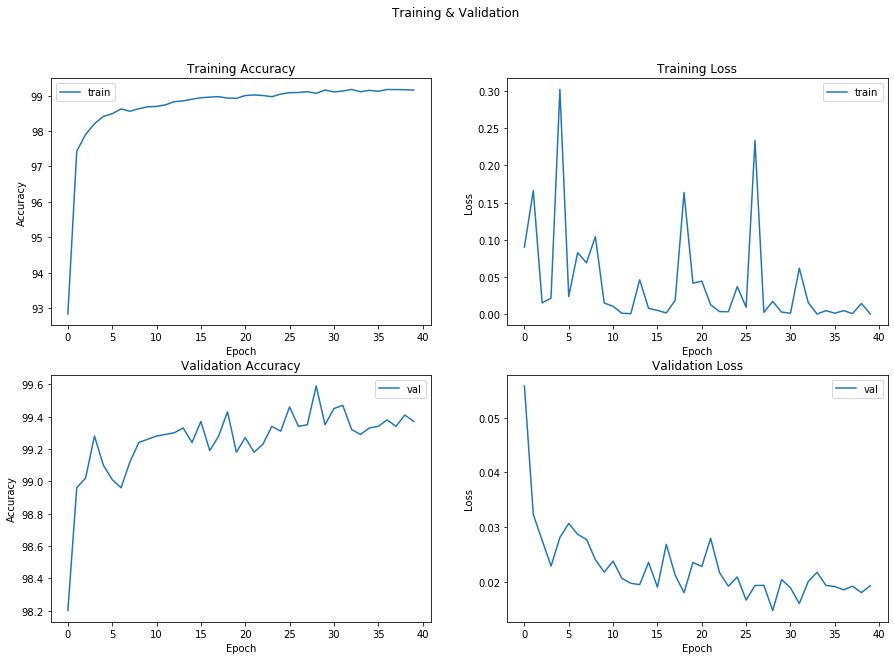

In [12]:
from torch.optim.lr_scheduler import StepLR

EPOCHS = 40
init_learning_rate = 0.199
gamma= (init_learning_rate - (0.0001/EPOCHS))/init_learning_rate

optimizer = optim.SGD(model.parameters(), lr=init_learning_rate, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

[(train_acc, train_loss), (val_acc, val_loss)] = train_n_test(model, optimizer, scheduler, device, train_loader, test_loader, EPOCHS)

plot_acc_loss(train_acc, val_acc, train_loss, val_loss)
